# Data Analysis Framework (dataelab) Tutorial

This notebook demonstrates the core functionality of the `arte.dataelab` framework for analyzing adaptive optics time series data.

## Overview

In this tutorial we will:
1. Generate synthetic time series data (modal coefficients)
2. Save the data in FITS format
3. Create a custom `Analyzer` class
4. Load and analyze the data using dataelab tools
5. Compute statistics and power spectral densities
6. Visualize the results

The dataelab framework provides a structured approach to:
- **Lazy data loading**: Files are loaded only when needed
- **Disk caching**: Expensive computations are cached automatically
- **Tag-based organization**: Each dataset is identified by a unique tag
- **Time series analysis**: Built on `arte.time_series` with统计和频域分析

## 1. Import Required Libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from astropy.io import fits
from astropy import units as u
import tempfile

from arte.dataelab.base_analyzer import BaseAnalyzer
from arte.dataelab.base_timeseries import BaseTimeSeries
from arte.dataelab.base_file_walker import AbstractFileNameWalker

print("✓ All imports successful")

✓ All imports successful


## 2. Generate Synthetic Time Series Data

We create a synthetic dataset representing modal coefficients (e.g., Zernike modes) evolving over time. Each mode is a sinusoid with different amplitude, frequency, and phase.

In [12]:
# Parameters
n_time_steps = 100  # Number of temporal samples
n_modes = 10        # Number of modes (ensemble elements)
sampling_freq = 1000.0  # Hz - sampling frequency
dt = 1.0 / sampling_freq  # Time step in seconds

# Create time vector
time_vector = np.arange(n_time_steps) * dt  # in seconds

# Generate synthetic modal coefficients
# Each mode is a sinusoid: A * sin(2*pi*f*t + phi)
amplitudes = np.random.uniform(0.5, 2.0, n_modes)  # Random amplitudes
frequencies = np.linspace(10, 100, n_modes)         # Frequencies from 10 to 100 Hz
phases = np.random.uniform(0, 2*np.pi, n_modes)     # Random phases

# Create data matrix [time, modes]
modal_coefficients = np.zeros((n_time_steps, n_modes))
for i in range(n_modes):
    modal_coefficients[:, i] = amplitudes[i] * np.sin(
        2 * np.pi * frequencies[i] * time_vector + phases[i]
    )

print(f"Generated data shape: {modal_coefficients.shape}")
print(f"Time range: {time_vector[0]:.4f} to {time_vector[-1]:.4f} seconds")
print(f"Mode amplitudes: {amplitudes}")
print(f"Mode frequencies (Hz): {frequencies}")

Generated data shape: (100, 10)
Time range: 0.0000 to 0.0990 seconds
Mode amplitudes: [1.85227482 0.77837022 0.96715451 1.55287809 0.76681519 1.4093002
 1.8439393  1.81423336 1.80465226 0.55132845]
Mode frequencies (Hz): [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]


## 3. Save Data to FITS File

We save both the modal coefficients and time vector in a FITS file with appropriate headers.

In [13]:
# Create temporary directory for our data files
temp_dir = Path(tempfile.mkdtemp())
data_dir = temp_dir / "dataelab_example"
data_dir.mkdir(exist_ok=True)

# Create FITS file for modal coefficients
modes_file = data_dir / "modal_coefficients.fits"
hdu_modes = fits.PrimaryHDU(modal_coefficients)
hdu_modes.header['EXTNAME'] = 'MODAL_COEFF'
hdu_modes.header['BUNIT'] = 'microns'  # Physical unit
hdu_modes.header['SAMPFREQ'] = sampling_freq
hdu_modes.header['NMODES'] = n_modes
hdu_modes.header['NFRAMES'] = n_time_steps
hdu_modes.writeto(modes_file, overwrite=True)

# Create FITS file for time vector
time_file = data_dir / "time_vector.fits"
hdu_time = fits.PrimaryHDU(time_vector)
hdu_time.header['EXTNAME'] = 'TIME'
hdu_time.header['BUNIT'] = 's'  # seconds
hdu_time.writeto(time_file, overwrite=True)

print(f"✓ Created FITS files in: {data_dir}")
print(f"  - {modes_file.name}: {modal_coefficients.shape}")
print(f"  - {time_file.name}: {time_vector.shape}")

✓ Created FITS files in: /var/folders/yy/y6mh4b390sj24kqkcp9nl2c40000gp/T/tmp0uaafein/dataelab_example
  - modal_coefficients.fits: (100, 10)
  - time_vector.fits: (100,)


## 4. Define Custom FileWalker and Analyzer

The dataelab framework uses two main components:
- **FileWalker**: Locates data files based on a tag
- **Analyzer**: Provides access to time series data and analysis methods

In [14]:
class ExampleFileWalker(AbstractFileNameWalker):
    """Locate data files for our example dataset"""
    
    def __init__(self, tag):
        """
        Parameters
        ----------
        tag : str or Path
            Path to the data directory
        """
        self._data_dir = Path(tag)
    
    def snapshot_dir(self, tag=None):
        """Return path to data directory"""
        return self._data_dir
    
    def modal_coefficients_file(self):
        """Return path to modal coefficients FITS file"""
        return self._data_dir / "modal_coefficients.fits"
    
    def time_vector_file(self):
        """Return path to time vector FITS file"""
        return self._data_dir / "time_vector.fits"


class ExampleAnalyzer(BaseAnalyzer):
    """Analyzer for synthetic modal coefficient data
    
    This analyzer provides access to:
    - Modal coefficients time series
    - Time vector
    - All statistical and spectral analysis methods from BaseTimeSeries
    
    Examples
    --------
    >>> analyzer = ExampleAnalyzer.get(data_dir)
    >>> modes = analyzer.modal_coefficients.get_data()
    >>> rms_per_mode = analyzer.modal_coefficients.time_rms()
    >>> psd = analyzer.modal_coefficients.power()
    """
    
    def __init__(self, tag, recalc=False):
        """Initialize analyzer
        
        Parameters
        ----------
        tag : str or Path
            Path to data directory containing FITS files
        recalc : bool, optional
            If True, clear cached results and recompute
        """
        super().__init__(tag, recalc)
        
        # Create file walker
        fw = ExampleFileWalker(tag)
        
        # Create time series for modal coefficients
        self.modal_coefficients = BaseTimeSeries(
            data=str(fw.modal_coefficients_file()),
            time_vector=str(fw.time_vector_file()),
            astropy_unit=u.micron,
            data_label="Modal Coefficients"
        )

print("✓ ExampleFileWalker and ExampleAnalyzer defined")

✓ ExampleFileWalker and ExampleAnalyzer defined


## 5. Initialize the Analyzer and Load Data

In [15]:
# Create analyzer instance
analyzer = ExampleAnalyzer.get(str(data_dir))

# Access the data (lazy loading - file is loaded only now)
modes_data = analyzer.modal_coefficients.get_data()
time_vec = analyzer.modal_coefficients.get_time_vector()

print(f"✓ Analyzer initialized")
print(f"  Data shape: {modes_data.shape}")
print(f"  Data unit: {analyzer.modal_coefficients.data_unit()}")
print(f"  Time vector shape: {time_vec.shape}")
print(f"  Sampling frequency: {1.0 / analyzer.modal_coefficients.delta_time:.1f} Hz")

✓ Analyzer initialized
  Data shape: (100, 10)
  Data unit: micron
  Time vector shape: (100,)
  Sampling frequency: 1000.0 Hz


## 6. Time-Domain Statistics

BaseTimeSeries provides methods for computing statistics over time.

In [16]:
# Compute statistics over time for each mode
time_mean = analyzer.modal_coefficients.time_average()
time_std = analyzer.modal_coefficients.time_std()
time_rms = analyzer.modal_coefficients.time_rms()

print("Time-domain statistics (per mode):")
print(f"  Mean: {time_mean}")
print(f"  Std:  {time_std}")
print(f"  RMS:  {time_rms}")

# Note: For sinusoids with zero mean, RMS ≈ amplitude/√2
print(f"\nExpected RMS (amp/√2): {amplitudes / np.sqrt(2)}")
print(f"Computed RMS:          {time_rms.value}")

Time-domain statistics (per mode):
  Mean: [ 1.13242749e-16  6.21724894e-17 -4.16333634e-17  1.11022302e-18
 -9.99200722e-18 -2.08721929e-16  1.24344979e-16  6.77236045e-16
  2.31759056e-16  7.54951657e-17] micron
  Std:  [1.30975608 0.55039086 0.68388151 1.09805063 0.54222022 0.99652573
 1.30386198 1.28285671 1.27608185 0.38984808] micron
  RMS:  [1.30975608 0.55039086 0.68388151 1.09805063 0.54222022 0.99652573
 1.30386198 1.28285671 1.27608185 0.38984808] micron

Expected RMS (amp/√2): [1.30975608 0.55039086 0.68388151 1.09805063 0.54222022 0.99652573
 1.30386198 1.28285671 1.27608185 0.38984808]
Computed RMS:          [1.30975608 0.55039086 0.68388151 1.09805063 0.54222022 0.99652573
 1.30386198 1.28285671 1.27608185 0.38984808]


## 7. Ensemble Statistics

Compute statistics across all modes at each time step.

Ensemble statistics shapes:
  Mean: (100,) (one value per time step)
  Std:  (100,)
  RMS:  (100,)


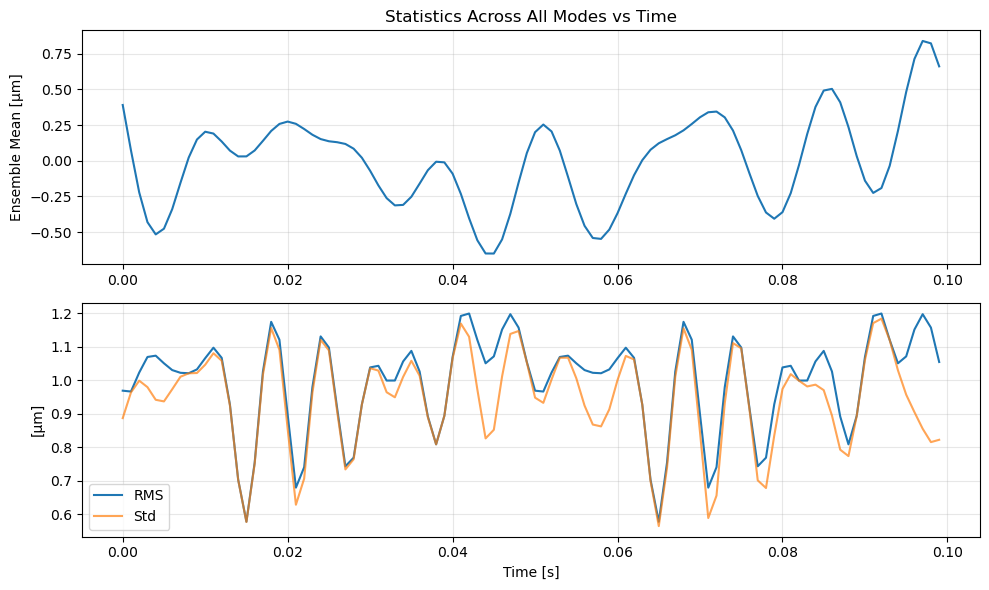

In [17]:
# Compute statistics across modes at each time step
ensemble_mean = analyzer.modal_coefficients.ensemble_average()
ensemble_std = analyzer.modal_coefficients.ensemble_std()
ensemble_rms = analyzer.modal_coefficients.ensemble_rms()

print(f"Ensemble statistics shapes:")
print(f"  Mean: {ensemble_mean.shape} (one value per time step)")
print(f"  Std:  {ensemble_std.shape}")
print(f"  RMS:  {ensemble_rms.shape}")

# Plot ensemble statistics evolution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(time_vec, ensemble_mean.value)
ax1.set_ylabel('Ensemble Mean [µm]')
ax1.set_title('Statistics Across All Modes vs Time')
ax1.grid(True, alpha=0.3)

ax2.plot(time_vec, ensemble_rms.value, label='RMS')
ax2.plot(time_vec, ensemble_std.value, label='Std', alpha=0.7)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[µm]')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Power Spectral Density Analysis

Compute the PSD using Welch's method to identify the frequency content of each mode.

PSD shape: (51, 10)
Frequency vector shape: (51,)
Frequency range: 0.0 to 500.0 Hz


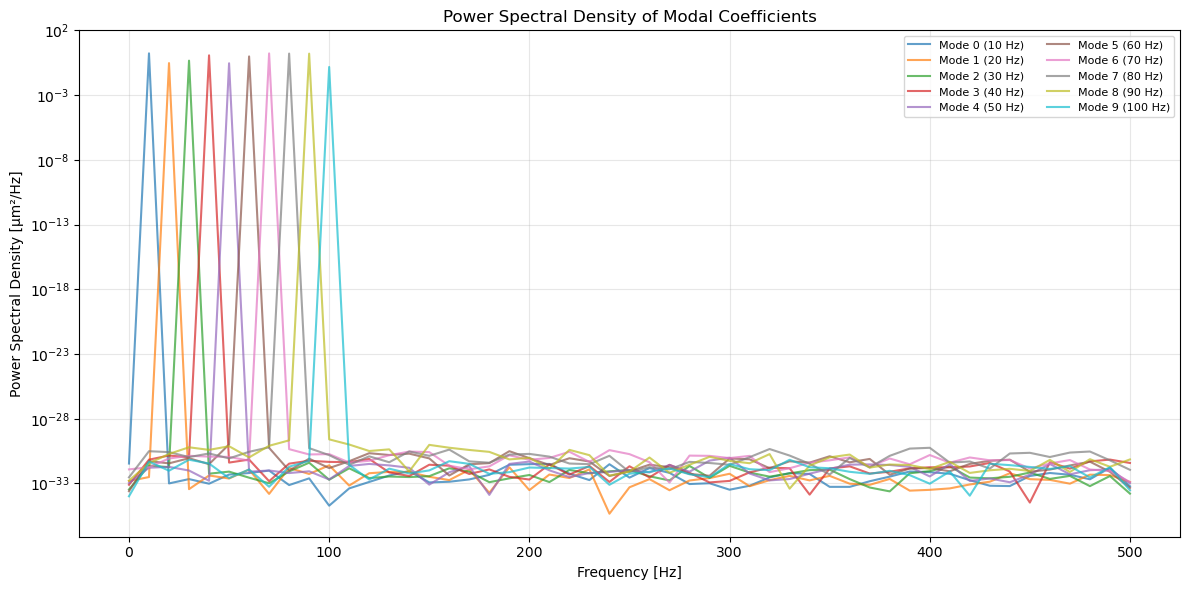


Expected frequencies: [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
Detected peak frequencies: [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]


In [18]:
# Compute PSD
psd = analyzer.modal_coefficients.power()
freq = analyzer.modal_coefficients.frequency()

print(f"PSD shape: {psd.shape}")
print(f"Frequency vector shape: {freq.shape}")
print(f"Frequency range: {freq[0]:.1f} to {freq[-1]:.1f} Hz")

# Plot PSD for all modes
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(n_modes):
    ax.semilogy(freq, psd[:, i], label=f'Mode {i} ({frequencies[i]:.0f} Hz)', alpha=0.7)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power Spectral Density [µm²/Hz]')
ax.set_title('Power Spectral Density of Modal Coefficients')
ax.grid(True, alpha=0.3, which='both')
ax.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# Find peak frequencies
peak_freqs = np.zeros(n_modes)
for i in range(n_modes):
    peak_idx = np.argmax(psd[:, i])
    peak_freqs[i] = freq[peak_idx]

print(f"\nExpected frequencies: {frequencies}")
print(f"Detected peak frequencies: {peak_freqs}")

## 9. Visualize Time Series Data

Plot the raw time series for selected modes.

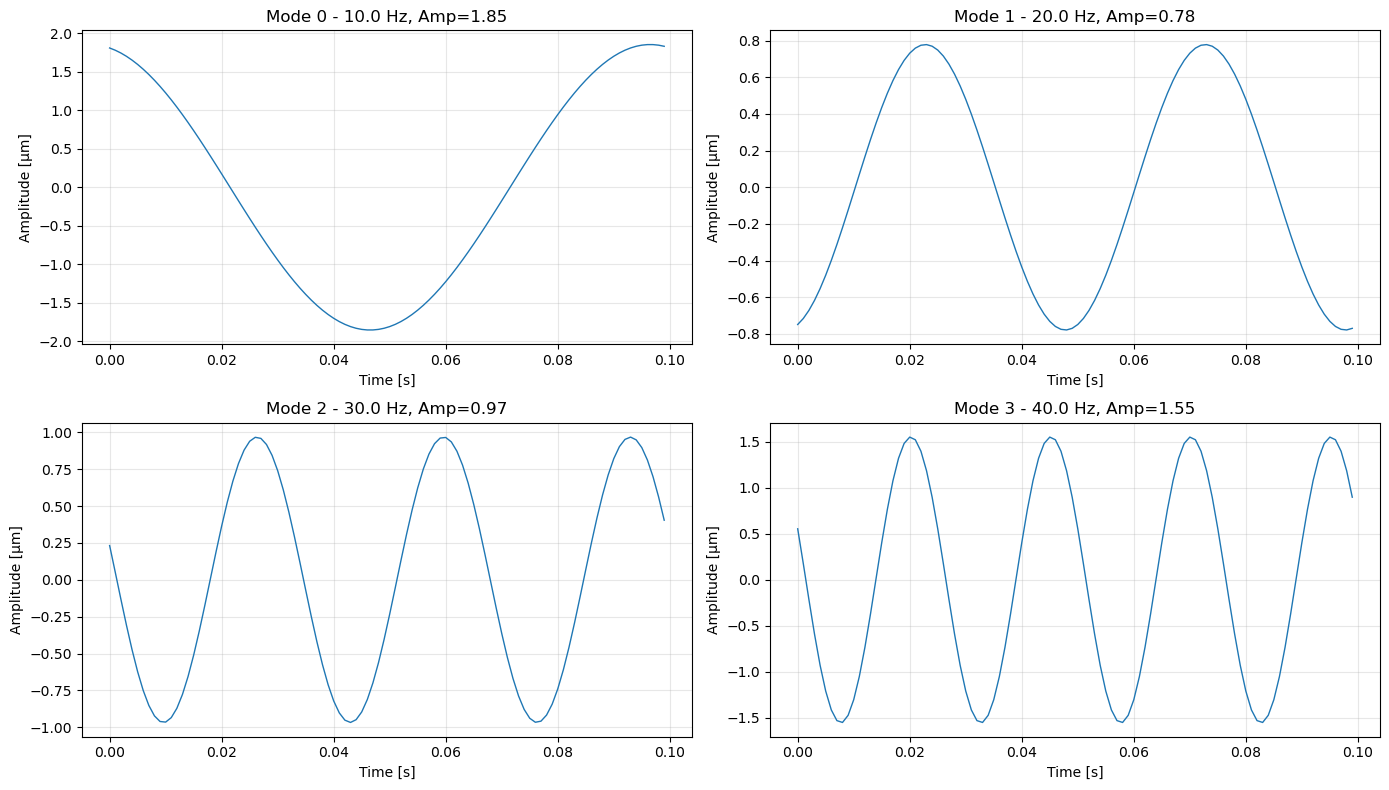

In [19]:
# Plot time series for first 4 modes
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    ax.plot(time_vec, modes_data[:, i].value, linewidth=1)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Amplitude [µm]')
    ax.set_title(f'Mode {i} - {frequencies[i]:.1f} Hz, Amp={amplitudes[i]:.2f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Time Filtering

The dataelab framework supports filtering data by time range.

In [21]:
# Analyze only a subset of the time series
# Note: Since time_vector is loaded from FITS without units, we use scalar values
start_time = 0.02  # seconds
end_time = 0.06    # seconds

# Get data for specific time range
filtered_data = analyzer.modal_coefficients.get_data(times=[start_time, end_time])
filtered_time_mean = analyzer.modal_coefficients.time_average(times=[start_time, end_time])

print(f"Full data shape: {modes_data.shape}")
print(f"Filtered data shape: {filtered_data.shape}")
print(f"Time range: {start_time} s to {end_time} s")
print(f"\nFiltered time mean: {filtered_time_mean}")

Full data shape: (100, 10)
Filtered data shape: (40, 10)
Time range: 0.02 s to 0.06 s

Filtered time mean: [-1.26886826e+00 -9.20824173e-02  1.20170145e-01 -4.03077615e-02
 -9.71445147e-17 -8.15431270e-02  1.23668593e-01  8.96159366e-03
 -1.09638033e-01 -1.24900090e-16] micron


## Summary

This tutorial demonstrated the core functionality of the `arte.dataelab` framework:

✅ **Data Generation**: Created synthetic time series (modal coefficients)  
✅ **File I/O**: Saved data in FITS format with proper metadata  
✅ **Custom Components**: Defined FileWalker and Analyzer classes  
✅ **Lazy Loading**: Data loaded automatically when accessed  
✅ **Statistics**: Computed time and ensemble statistics (mean, std, rms)  
✅ **Spectral Analysis**: Power spectral density with peak detection  
✅ **Time Filtering**: Analyzed specific time intervals  

### Key Concepts

- **Tag-based organization**: Each dataset has a unique identifier
- **BaseAnalyzer**: Coordinates data access and analysis
- **BaseTimeSeries**: Provides statistical and spectral analysis methods
- **BaseFileWalker**: Locates data files
- **Lazy loading**: Files loaded only when needed
- **Unit support**: Physical units via astropy.units

### Next Steps

For real-world applications:
- Add caching with `@cache_on_disk` decorator for expensive computations
- Implement AnalyzerSet for multi-tag analysis
- Use DataLoader for more sophisticated file handling
- Add custom indexing for mode selection
- Integrate with actual AO telemetry data

See the arte.dataelab documentation for more details!